# Goal: Detect vehicles in a video and add box around it
    
    1) Uses CV2 for object identification
    2) Uses Vehicle/NonVehicle dataset for training
    3) Uses SVC for training the model
    4) Image Process Pipeline:
            a) Extract features using Spatial, Histogram and HOG
            b) Determine narrower ROI for object detection in image
            c) Apply HeatMap
            d) Remove False Positive using heatmap thresholding
            e) Find object using sliding window
    5) Extract images from video and process single image through pipeline

In [32]:
import cv2
import glob
import time
import pickle
import collections
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
import skimage
from skimage import data, color, exposure
import matplotlib.image as mpimg
%matplotlib inline

In [33]:
# Get all Car and Non Car images from the dataset
cars     = glob.glob("./training_data/vehicles/*/*.png")
non_cars = glob.glob("./training_data/non-vehicles/*/*.png")

In [34]:
# Find the size of each data set
print(len(cars), len(non_cars))

8792 8968


# Image Processing & Feature Extraction functions

In [35]:
#Define functions that will be used later
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    fhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range) #First channel histogram
    shist = np.histogram(img[:,:,1], bins=nbins, range=bins_range) # Second channel histogram
    thist = np.histogram(img[:,:,2], bins=nbins, range=bins_range) # Third channel histogram
    # Generating bin centers
    bin_edges = fhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((fhist[0], shist[0], thist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features, fhist, shist, thist, bin_centers


def bin_spatial_features(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
     if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
     else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
def color_hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs, color_space='RGB', spatial_size=(16, 16),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to RGB color space
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial_features(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist_features(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Hyper parameters for tuning the output

In [36]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell #16
cell_per_block = 2 # HOG cells per block #2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()
SAMPLE = False   # only during debug
sample_size = 1000  # Only during debug

if SAMPLE:
    cars_samples    = np.random.choice(cars, sample_size, replace=False)
    notcars_samples  = np.random.choice(non_cars, sample_size, replace=False)
else:
    cars_samples = cars
    notcars_samples = non_cars

# Extract Features for all images in the data set (Cars & Non Cars)
car_features = extract_features(cars_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars_samples, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


# Stack the features horizontally and Normalize them
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Train the model

In [ ]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)

# Split data 80/20 for training
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


# Save the model 

In [ ]:
pickle_data = {'scaler': X_scaler, 'svc': svc, 'orient': orient, 
               'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 'spatial_size': spatial_size,
               'hist_bins':hist_bins}

with open('svc_classifier.p', 'wb') as f:
    pickle.dump(pickle_data, f)

# Use the trained model for object detection

1) Extract feature for single image using Spatial, Histogram and HOG

2) Apply Heat Map & Thresholding to remove false positives

3) Use Sliding Window

In [37]:
#Define functions to extract features from test images

def single_img_features(img, color_space='HSV', spatial_size=(16, 16), 
                        hist_bins=16, orient=6, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=2,
                        spatial_feat=False, hist_feat=False, hog_feat=True): 
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial_features(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist_features(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

##Sliding window implementation
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



# Test sliding window in smaller ROI

In [43]:
# Load parameters and the model from the saved file 
dist_pickle = pickle.load( open("svc_classifier.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

# Use these parameter for processing test and video images
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()
xy_window = [ (96,96),(128,128)]
y_start_stop = [[400, 600], [400, None]]

75
76
Windows Final 151


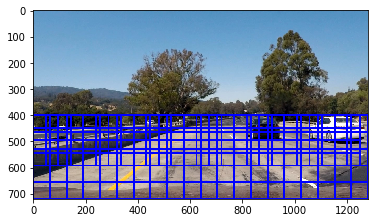

In [44]:
image = cv2.imread('./test_images/test1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#xy_window = [(64,64), (96,96), (128,128), (256,256)]
#y_start_stop = [[400, 600], [400, 600], [400, None], [400, None]]

windows_temp = []
for i in range(len(xy_window)):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop[i], 
                        xy_window=xy_window[i], xy_overlap=(0.5, 0.5))
    windows_temp.append(windows) 

#Flatten windows_temp
windows_final = sum(windows_temp, [])

print("Windows Final",len(windows_final))
window_img = draw_boxes(image, windows_final, color=(0, 0, 255), thick=6)   

plt.imshow(window_img)

# Test images showing heat map

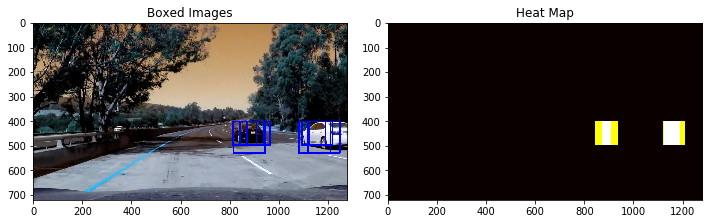

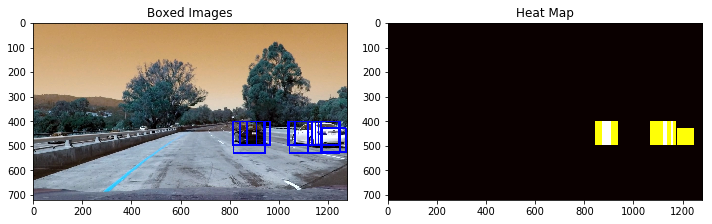

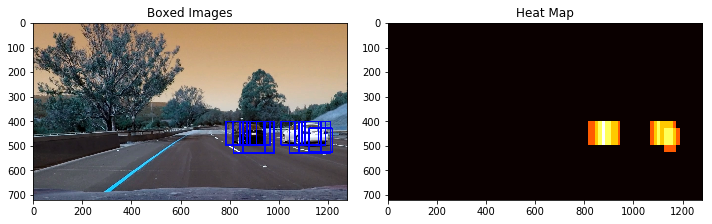

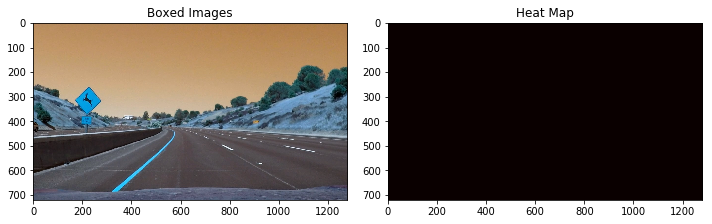

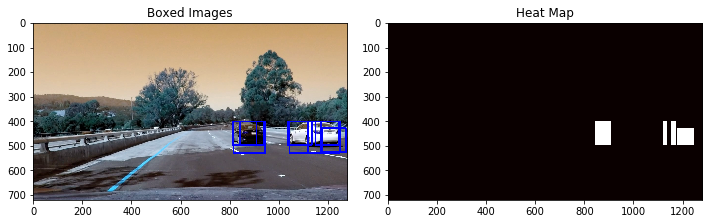

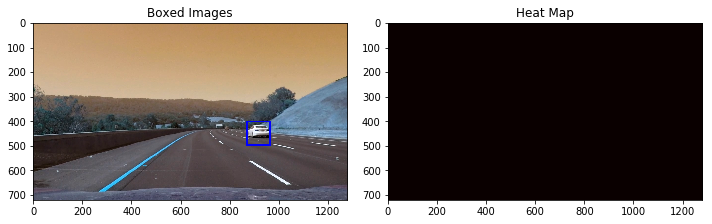

In [45]:
files = glob.glob("./test_images/*.jpg")

for file in files:
    image = cv2.imread(file)
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.7, 0.7))
        #print(len(windows))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    
    
    hot_windows = search_windows(image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)     
    
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    # Plot Original Vs Heat Map images
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(window_img)
    plt.title('Boxed Images')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

In [61]:
def hot_windows(input_image, windows, classifier, scaler, draw=True):
    """Adds bounding boxes from `input_image` (one array of arrays) to
    the global variable `bboxes_list`'.
    If `draw` is True, returns image overlaid with bounding boxes.
    """

    xy_window = [(96,96), (128,128)]
    y_start_stop = [[400, 650], [400, None]]

    windows_temp = []
    for i in range(len(xy_window)):
        windows = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop[i], 
                            xy_window=xy_window[i], xy_overlap=(0.6, 0.6))
        #print(len(windows))
        windows_temp.append(windows) 

    #Flatten windows_temp
    windows_final = sum(windows_temp, [])
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off
    y_start_stop = [400, None] # Min and max in y to search in slide_window()


    hot_windows = search_windows(input_image, windows_final, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
   
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img
    
    return hot_windows

In [62]:
def process_image(image, n_frames=20, threshold=12):  
     
    hot_windows_temp =[]
    global hot_windows_list
    global windows
    global hot_windows_final
   
    windows = hot_windows(image, windows, svc, X_scaler, draw=False)
    hot_windows_list.append(windows)
   
    if len(hot_windows_list) <= n_frames:
         hot_windows_final = sum(hot_windows_list, []) # Add windows from all available frames
    
    #Look at last n frames and append all hot windows found
    else: 
        for val in hot_windows_list[(len(hot_windows_list) - n_frames -1) : (len(hot_windows_list)-1)]:
            hot_windows_temp.append(val)
    #Flatten this list
        hot_windows_final = sum(hot_windows_temp, [])
    
    #draw_image = np.copy(image)
    #window_img = draw_boxes(draw_image, hot_windows_final, color=(0, 0, 255), thick=6)   
    
    #Create a frame_heatmap
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    frame_heatmap = add_heat(frame_heatmap, hot_windows_final)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    labels = label(frame_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

[MoviePy] >>>> Building video p5_vehicle_detection.mp4
[MoviePy] Writing video p5_vehicle_detection.mp4


100%|█████████▉| 1260/1261 [13:48<00:00,  1.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p5_vehicle_detection.mp4 

CPU times: user 13min 45s, sys: 2.51 s, total: 13min 48s
Wall time: 13min 49s


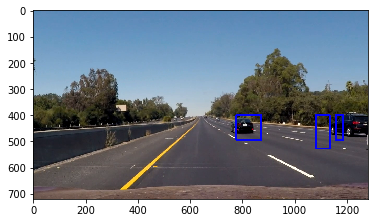

In [65]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Read Video
video = VideoFileClip("project_video.mp4")

# Process each image from video
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!

# Output filename
output = "p5_vehicle_detection.mp4"

%time project_clip.write_videofile(output, audio=False)

In [20]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('p5_vehicle_detection.mp4'))